In [1]:
!pip install torch torchvision

# Task 1

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Defining the transformations to apply on the images.
# Here we convert images to tensors and normalize their pixel values to have a mean of 0.5 and a standard deviation of 0.5 for each channel.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Defining the batch size for data loading.
batch_size = 32

# Loading the CIFAR-10 training dataset from the local './data' directory, applying the defined transformations, and download the data if not locally available.
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Loading the CIFAR-10 testing dataset similarly as for the training dataset.
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Creating DataLoader for training data: shuffles the training data and uses multiple workers to load the data in parallel, improving loading efficiency.
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Creating DataLoader for test data: does not shuffle the data and also uses multiple workers for parallel data loading.
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# This is just to check if DataLoader is working and to see the size of each batch
# Comment out this part for the actual training to avoid unnecessary outputs.
"""for images, labels in trainloader:
    print('Batch size:', images.size(0))
    print('Image tensor:', images)
    print('Labels:', labels)
    break  # Break here to only show the first batch and not flood the output"""

"for images, labels in trainloader:\n    print('Batch size:', images.size(0))\n    print('Image tensor:', images)\n    print('Labels:', labels)\n    break  # Break here to only show the first batch and not flood the output"

# Task 2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        # Number of convolutional layers, input channels, and output channels for this block
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # List of convolutional layers with a 3x3 kernel and padding to maintain spatial dimensions
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(num_layers)
        ])
        
        # Fully connected layer to calculate the blending weights for the outputs of convolutional layers
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Perform adaptive average pooling to reduce each feature map to a single value
        spatial_avg = F.adaptive_avg_pool2d(x, (1, 1)).view(x.shape[0], -1)
        
        # Calculate the softmax of the output from the fully connected layer to get blending weights
        weights = torch.softmax(self.fc(spatial_avg), dim=1)
        
        # Apply each convolutional layer to the input and collect the outputs
        conv_outputs = [conv(x) for conv in self.conv_layers]
        # Multiply each output by its corresponding weight and sum them to get the final output of the block
        combined = torch.stack(conv_outputs, dim=2) * weights.unsqueeze(2)
        combined = torch.sum(combined, dim=2)
        return combined

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_layers=None):
        super(OutputBlock, self).__init__()
        # Default to an empty list of hidden layers if none are provided
        if hidden_layers is None:
            hidden_layers = []
        
        # Start building the layer sequence with flattening the input tensor
        layers = [nn.Flatten(start_dim=1)]
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_channels, hidden_size))
            layers.append(nn.ReLU())
            in_channels = hidden_size  # Update the input channel size for the next layer
        
        # Output layer for classification
        layers.append(nn.Linear(in_channels, num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # Apply global average pooling to reduce spatial dimensions before feeding into the classifier
        x = x.mean([2, 3])
        return self.layers(x)

class CustomCNN(nn.Module):
    def __init__(self, num_blocks, num_layers_per_block, in_channels, block_out_channels, num_classes, hidden_layers=None):
        super(CustomCNN, self).__init__()
        # Construct a list of intermediate blocks
        self.blocks = nn.ModuleList()
        
        for _ in range(num_blocks):
            self.blocks.append(IntermediateBlock(in_channels, block_out_channels, num_layers_per_block))
            in_channels = block_out_channels  # Set the output of the current block as the input to the next
        
        # Initialize the output block
        self.output_block = OutputBlock(block_out_channels, num_classes, hidden_layers)

    def forward(self, x):
        # Sequentially pass input through all intermediate blocks
        for block in self.blocks:
            x = block(x)
        
        # Final processing through the output block
        x = self.output_block(x)
        return x

# Example instantiation and structure checking of the network model
Initial_model = CustomCNN(num_blocks=3, num_layers_per_block=2, in_channels=3, block_out_channels=64, num_classes=10, hidden_layers=[120, 84])
print(Initial_model)


CustomCNN(
  (blocks): ModuleList(
    (0): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-1): 2 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=3, out_features=2, bias=True)
    )
    (1-2): 2 x IntermediateBlock(
      (conv_layers): ModuleList(
        (0-1): 2 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (output_block): OutputBlock(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=64, out_features=120, bias=True)
      (2): ReLU()
      (3): Linear(in_features=120, out_features=84, bias=True)
      (4): ReLU()
      (5): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)


# Task 3

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Intermediate block of the network which includes convolutional layers and a mechanism to blend their outputs
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        # Multiple convolutional layers are initialized in a ModuleList
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(num_layers)
        ])
        # A fully connected layer to compute weights for blending the outputs of convolutional layers
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Adaptive average pooling to reduce each channel to a single value per feature map
        spatial_avg = F.adaptive_avg_pool2d(x, (1, 1)).view(x.shape[0], -1)
        # Compute weights for each convolutional layer's output
        weights = torch.softmax(self.fc(spatial_avg), dim=1)
        
        # Stack outputs from all convolutional layers and blend them using computed weights
        conv_outputs = torch.stack([conv(x) for conv in self.conv_layers], dim=0)
        combined = torch.zeros_like(conv_outputs[0])
        for i, weight in enumerate(weights.t()):
            combined += weight.view(-1, 1, 1, 1) * conv_outputs[i]
        
        return combined

# Output block of the network that classifies the features extracted by intermediate blocks
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_layers=None):
        super(OutputBlock, self).__init__()
        # Sequence of layers including linear transformations and non-linear activations
        layers = []
        for hidden_size in hidden_layers or []:
            layers.extend([
                nn.Linear(in_channels, hidden_size),
                nn.ReLU()
            ])
            in_channels = hidden_size
        layers.append(nn.Linear(in_channels, num_classes)) # Final linear layer for classification
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        # Global average pooling to condense each feature map to a single value
        x = x.mean([2, 3])
        # Pass through the sequence of layers
        x = self.layers(x)
        return x

# Custom CNN composed of multiple intermediate blocks and a final output block
class CustomCNN(nn.Module):
    def __init__(self, num_blocks, num_layers_per_block, in_channels, block_out_channels, num_classes, hidden_layers=None):
        super(CustomCNN, self).__init__()
        # Initialize a sequence of intermediate blocks
        self.blocks = nn.ModuleList([
            IntermediateBlock(in_channels if i == 0 else block_out_channels, block_out_channels, num_layers_per_block)
            for i in range(num_blocks)
        ])
        # Initialize the output block
        self.output_block = OutputBlock(block_out_channels, num_classes, hidden_layers)
    
    def forward(self, x):
        # Pass input through each block in sequence
        for block in self.blocks:
            x = block(x)
        # Pass the output of the last block to the output block
        x = self.output_block(x)
        return x

# Set up data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate the model with specific configurations
model = CustomCNN(
    num_blocks=3, 
    num_layers_per_block=2, 
    in_channels=3, 
    block_out_channels=64, 
    num_classes=10, 
    hidden_layers=[120, 84]
)


# Configuration for the device, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Training function with accuracy calculation
def train_model(model, criterion, optimizer, trainloader, testloader, device, epochs=10):
    model.train()
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and print the training accuracy for the current epoch
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        
        # Evaluate on the test set
        test_accuracy = test_model(model, testloader, device)
        test_accuracies.append(test_accuracy)

        # Print loss and accuracy
        print(f'Epoch {epoch + 1}: Loss: {running_loss / len(trainloader):.3f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_accuracies, test_accuracies

# Testing function
def test_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Main training loop with model, criterion, optimizer, and datasets defined
num_epochs = 20
train_accuracies, test_accuracies = train_model(model, criterion, optimizer, trainloader, testloader, device, epochs=num_epochs)


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1: Loss: 2.301, Train Accuracy: 11.25%, Test Accuracy: 14.65%
Epoch 2: Loss: 2.267, Train Accuracy: 15.95%, Test Accuracy: 17.28%
Epoch 3: Loss: 2.119, Train Accuracy: 19.27%, Test Accuracy: 20.56%
Epoch 4: Loss: 2.082, Train Accuracy: 20.66%, Test Accuracy: 20.97%
Epoch 5: Loss: 2.063, Train Accuracy: 21.60%, Test Accuracy: 22.12%
Epoch 6: Loss: 2.044, Train Accuracy: 22.72%, Test Accuracy: 23.35%
Epoch 7: Loss: 2.027, Train Accuracy: 23.50%, Test Accuracy: 24.52%
Epoch 8: Loss: 2.015, Train Accuracy: 24.00%, Test Accuracy: 24.93%
Epoch 9: Loss: 2.006, Train Accuracy: 24.63%, Test Accuracy: 25.37%
Epoch 10: Loss: 2.000, Train Accuracy: 24.93%, Test Accuracy: 25.56%
Epoch 11: Loss: 1.996, Train Accuracy: 24.91%, Test Accuracy: 25.62%
Epoch 12: Loss: 1.992, Train Accuracy: 25.01%, Test Accuracy: 25.15%
Epoch 13: Loss: 1.990, Train Accuracy: 25.25%, Test Accuracy: 26.07%
Epoch 14: Loss: 1.987, Train Accuracy: 25.37%, Test Accuracy: 25.75%
Epoch 15: Loss: 1.984, Train Accuracy: 25.3

# Task 4

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Defining the CNN model with convolutional, pooling, normalization, and dropout layers for robust feature learning.
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Augmentation and preprocessing techniques to enhance model generalization.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 dataset loading with transformations for training and testing.
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# Model instantiation, setup for loss computation, and optimizer configuration.
model = CustomCNN(num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Training function with accuracy calculation
def train_model(model, criterion, optimizer, trainloader, testloader, device, epochs=10):
    model.train()
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and print the training accuracy for the current epoch
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        
        # Evaluate on the test set
        test_accuracy = test_model(model, testloader, device)
        test_accuracies.append(test_accuracy)

        # Print loss and accuracy
        print(f'Epoch {epoch + 1}: Loss: {running_loss / len(trainloader):.3f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_accuracies, test_accuracies

# Testing function
def test_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Main training loop with model, criterion, optimizer, and datasets defined above
num_epochs = 30
train_accuracies, test_accuracies = train_model(model, criterion, optimizer, trainloader, testloader, device, epochs=num_epochs)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Loss: 1.835, Train Accuracy: 31.11%, Test Accuracy: 47.08%
Epoch 2: Loss: 1.342, Train Accuracy: 50.98%, Test Accuracy: 61.48%
Epoch 3: Loss: 1.113, Train Accuracy: 59.97%, Test Accuracy: 64.29%
Epoch 4: Loss: 0.997, Train Accuracy: 64.51%, Test Accuracy: 71.25%
Epoch 5: Loss: 0.895, Train Accuracy: 68.12%, Test Accuracy: 73.27%
Epoch 6: Loss: 0.821, Train Accuracy: 71.02%, Test Accuracy: 74.60%
Epoch 7: Loss: 0.767, Train Accuracy: 73.14%, Test Accuracy: 77.86%
Epoch 8: Loss: 0.715, Train Accuracy: 75.05%, Test Accuracy: 79.48%
Epoch 9: Loss: 0.678, Train Accuracy: 76.22%, Test Accuracy: 79.78%
Epoch 10: Loss: 0.653, Train Accuracy: 77.21%, Test Accuracy: 80.18%
Epoch 11: Loss: 0.624, Train Accuracy: 78.21%, Test Accuracy: 81.19%
Epoch 12: Loss: 0.597, Train Accuracy: 79.06%, Test Accuracy: 81.04%
Epoch 13: Loss: 0.577, Train Accuracy: 79.86%, Test Accuracy: 82.66%
Epoch 14: Loss: 0.555, Train Accurac

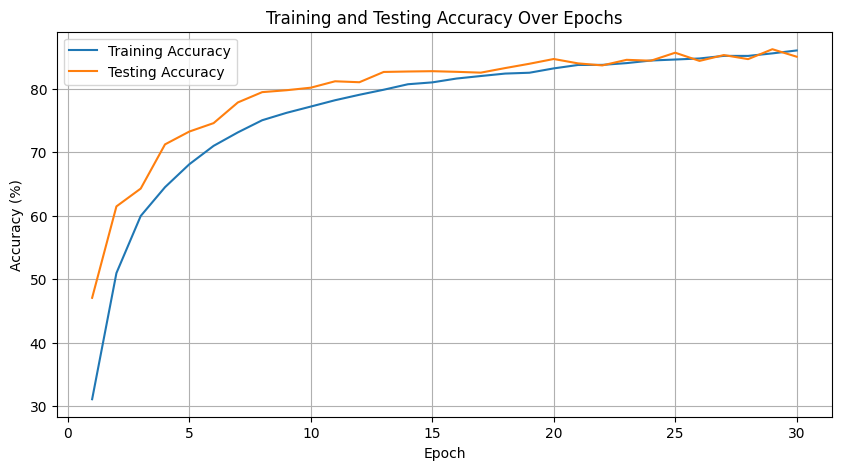

In [7]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))  # Epochs range from 1 to 40

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()